### Stock Market Prediction And Forecasting Using Stacked LSTM
# forcasting for the next 30 days

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('TSLA.csv')

In [3]:
df.head()

Date       Open       High        Low      Close  Adj Close  \
0  2017-02-27  16.544666  16.557333  16.134001  16.415333  16.415333   
1  2017-02-28  16.279333  16.733334  16.260000  16.666000  16.666000   
2  2017-03-01  16.945333  16.990000  16.607332  16.667999  16.667999   
3  2017-03-02  16.647333  16.885332  16.551332  16.698668  16.698668   
4  2017-03-03  16.716000  16.793333  16.600000  16.771334  16.771334   

      Volume  
0  171912000  
1   91171500  
2   72142500  
3   50277000  
4   43791000

In [4]:
df.tail()

Date        Open        High         Low       Close   Adj Close  \
1253  2022-02-16  304.683319  308.809998  300.403320  307.796661  307.796661   
1254  2022-02-17  304.420013  306.166656  291.366669  292.116669  292.116669   
1255  2022-02-18  295.333344  295.623322  279.203339  285.660004  285.660004   
1256  2022-02-22  278.043335  285.576660  267.033325  273.843323  273.843323   
1257  2022-02-23  276.809998  278.433319  253.520004  254.679993  254.679993   

        Volume  
1253  51294300  
1254  55178400  
1255  68501700  
1256  83288100  
1257  95256900

In [5]:
df1=df.reset_index()['Close']

In [6]:
df1

0        16.415333
1        16.666000
2        16.667999
3        16.698668
4        16.771334
           ...    
1253    307.796661
1254    292.116669
1255    285.660004
1256    273.843323
1257    254.679993
Name: Close, Length: 1258, dtype: float64

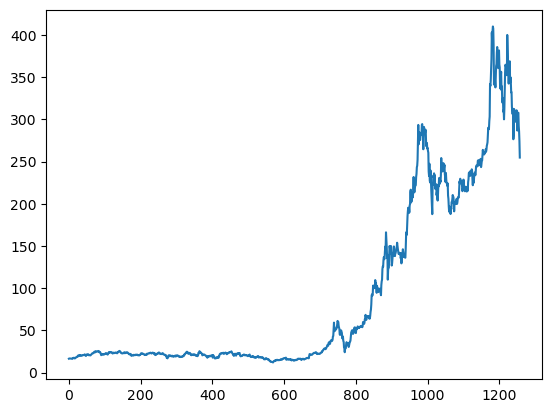

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [9]:
import numpy as np

In [10]:
df1

0        16.415333
1        16.666000
2        16.667999
3        16.698668
4        16.771334
           ...    
1253    307.796661
1254    292.116669
1255    285.660004
1256    273.843323
1257    254.679993
Name: Close, Length: 1258, dtype: float64

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
print(df1)

[[0.01126524]
 [0.01189499]
 [0.01190001]
 ...
 [0.68769367]
 [0.6580064 ]
 [0.609862  ]]


In [13]:
df1.shape

(1258, 1)

In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(1006, 252)

In [16]:
train_data.shape

(1006, 1)

In [17]:
test_data.shape

(252, 1)

# function for generating sequence

In [18]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)


In [20]:
print(X_train.shape), print(y_train.shape)

(905, 100)
(905,)


(None, None)

In [24]:
X_test, ytest = create_dataset(test_data, time_step)

In [25]:
print(X_test.shape), print(ytest.shape)

(151, 100)
(151,)


(None, None)

In [26]:
X_test.shape

(151, 100)

In [27]:
ytest.shape

(151,)

# Reshaping data for compatibility with lstm

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
X_train.shape

(905, 100, 1)

In [30]:
y_train.shape

(905,)

In [31]:
X_test.shape

(151, 100, 1)

In [32]:
ytest.shape

(151,)

# Model Building 

In [33]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [34]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1),activation='tanh'))
model.add(LSTM(50,return_sequences=True,activation='tanh'))
model.add(LSTM(50,return_sequences=False,activation='tanh'))
model.add(Dense(25))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer='adam')


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52,346
Trainable params: 52,346
Non-traina

In [36]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
15/15 [==============================] - 9s 225ms/step - loss: 0.0489 - val_loss: 0.0938
Epoch 2/20
15/15 [==============================] - 2s 157ms/step - loss: 0.0251 - val_loss: 0.0640
Epoch 3/20
15/15 [==============================] - 2s 159ms/step - loss: 0.0141 - val_loss: 0.0614
Epoch 4/20
15/15 [==============================] - 2s 156ms/step - loss: 0.0123 - val_loss: 0.0674
Epoch 5/20
15/15 [==============================] - 2s 161ms/step - loss: 0.0119 - val_loss: 0.0487
Epoch 6/20
15/15 [==============================] - 2s 148ms/step - loss: 0.0117 - val_loss: 0.0475
Epoch 7/20
15/15 [==============================] - 2s 148ms/step - loss: 0.0117 - val_loss: 0.0451
Epoch 8/20
15/15 [==============================] - 2s 151ms/step - loss: 0.0133 - val_loss: 0.0468
Epoch 9/20
15/15 [==============================] - 2s 142ms/step - loss: 0.0110 - val_loss: 0.0745
Epoch 10/20
15/15 [==============================] - 2s 136ms/step - loss: 0.0162 - val_loss: 0.0577

# Model's prediction on training and testing data and error calculation and visualization

In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

5/5 [==============================] - 0s 25ms/step


In [38]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_absolute_error
mean_absolute_error(scaler.inverse_transform(y_train.reshape(-1,1)),train_predict)

3.2829712410852254

In [40]:
### Test Data RMSE
#math.sqrt(mean_squared_error(scaler.inverse_transform(ytest.reshape(-1,1)),test_predict))
mean_absolute_error(scaler.inverse_transform(ytest.reshape(-1,1)),test_predict)

20.57110825946813

In [41]:
scaler.inverse_transform(ytest.reshape(-1,1))

array([[220.166672],
       [218.429993],
       [216.419998],
       [214.460007],
       [219.206665],
       [214.926666],
       [215.660004],
       [225.78334 ],
       [229.066666],
       [236.556671],
       [236.580002],
       [236.973328],
       [238.210007],
       [233.03334 ],
       [237.919998],
       [236.66333 ],
       [235.940002],
       [240.75    ],
       [239.056671],
       [228.723328],
       [221.903336],
       [229.66333 ],
       [224.490005],
       [226.753326],
       [235.433334],
       [236.16333 ],
       [237.066666],
       [233.720001],
       [237.306671],
       [243.636673],
       [245.240005],
       [244.696671],
       [244.130005],
       [244.523331],
       [250.973328],
       [251.289993],
       [251.619995],
       [245.42334 ],
       [247.666672],
       [248.16333 ],
       [251.943329],
       [252.330002],
       [253.16333 ],
       [243.389999],
       [246.460007],
       [250.646667],
       [251.213333],
       [258.1

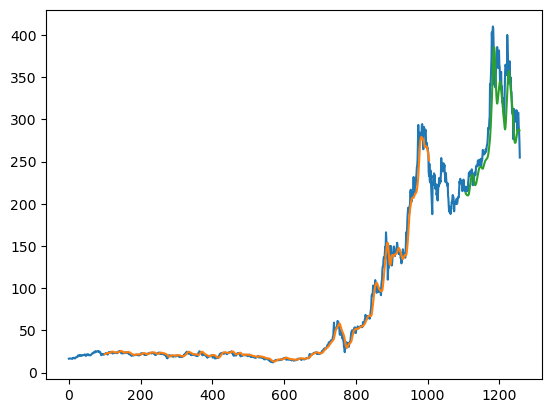

In [42]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(figsize=(12,5))
plt.show()

In [43]:
train_predict.reshape(905).shape

(905,)

In [44]:
y_train.shape

(905,)

<Figure size 2000x500 with 0 Axes>

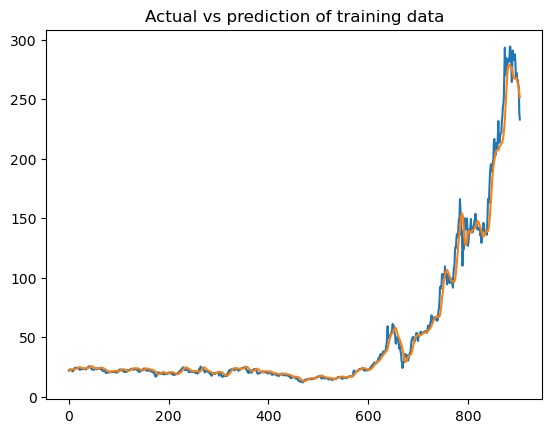

<Figure size 2000x500 with 0 Axes>

In [45]:

plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)))
plt.plot(train_predict)
plt.title("Actual vs prediction of training data")
plt.figure(figsize=(20,5))

In [46]:
test_predict

array([[212.59831],
       [211.59154],
       [210.9279 ],
       [210.48477],
       [210.09895],
       [209.97185],
       [209.91177],
       [209.88771],
       [210.4144 ],
       [211.7139 ],
       [214.04305],
       [217.16962],
       [220.70885],
       [224.31602],
       [227.38693],
       [229.90892],
       [231.78238],
       [232.96417],
       [233.7652 ],
       [234.23035],
       [233.8636 ],
       [232.30923],
       [230.16309],
       [227.58365],
       [224.97018],
       [223.05632],
       [222.09235],
       [222.07207],
       [222.62315],
       [223.65535],
       [225.31653],
       [227.53249],
       [230.0254 ],
       [232.48224],
       [234.6913 ],
       [236.85385],
       [238.9515 ],
       [240.8976 ],
       [242.25352],
       [243.02667],
       [243.31271],
       [243.42426],
       [243.51288],
       [243.6688 ],
       [243.37021],
       [242.69977],
       [242.00755],
       [241.48276],
       [241.55199],
       [242.5364 ],


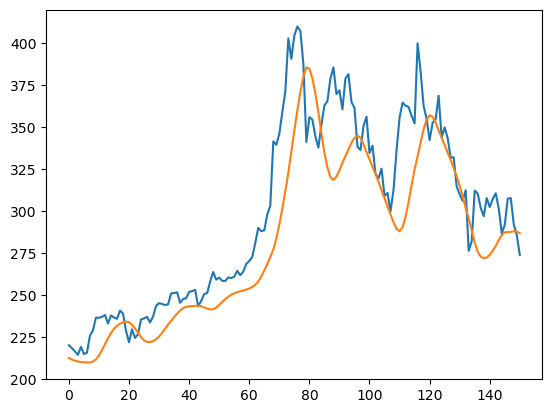

In [47]:
plt.plot(scaler.inverse_transform(ytest.reshape(-1,1)))
plt.plot(test_predict)

In [48]:
len(test_data)

252

In [49]:
x_input=test_data[152:].reshape(1,-1)
x_input.shape


(1, 100)

In [50]:
temp_input=list(x_input)

temp_input=temp_input[0].tolist()

In [51]:
temp_input

[0.6192246226690719,
 0.6245088655557454,
 0.6237216179207995,
 0.6255304899171252,
 0.634625149032003,
 0.6278250684930942,
 0.6332266140534868,
 0.6447665054491639,
 0.6492551422164843,
 0.6553182742536963,
 0.6760113994753896,
 0.6986892765905848,
 0.693798580895663,
 0.695079888570022,
 0.7186956695373122,
 0.7318266902651779,
 0.8282829998818104,
 0.8228982441474755,
 0.8391697411669561,
 0.8719806162149049,
 0.902932403039797,
 0.9821458075023001,
 0.9515038448475562,
 0.9865590797324243,
 0.9999999999999999,
 0.9934512417773439,
 0.9439166699251439,
 0.8271440678220738,
 0.8643682929820274,
 0.860650033629396,
 0.8354514818143245,
 0.8186775662710235,
 0.8532973158276169,
 0.8820047428155898,
 0.88817666830299,
 0.9222437052271514,
 0.9388333823888686,
 0.8987702998744834,
 0.9046072553935889,
 0.8760673523307035,
 0.9221851305160129,
 0.9286920259717077,
 0.8870210242990763,
 0.8783116317734234,
 0.8200007367123436,
 0.8150096035393224,
 0.850801789438206,
 0.8652141153281115,


# Prediction for the next 30 days using 100 days look back period

In [52]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.6717072]
101
1 day input [0.62450887 0.62372162 0.62553049 0.63462515 0.62782507 0.63322661
 0.64476651 0.64925514 0.65531827 0.6760114  0.69868928 0.69379858
 0.69507989 0.71869567 0.73182669 0.828283   0.82289824 0.83916974
 0.87198062 0.9029324  0.98214581 0.95150384 0.98655908 1.
 0.99345124 0.94391667 0.82714407 0.86436829 0.86065003 0.83545148
 0.81867757 0.85329732 0.88200474 0.88817667 0.92224371 0.93883338
 0.8987703  0.90460726 0.87606735 0.92218513 0.92869203 0.88702102
 0.87831163 0.82000074 0.8150096  0.85080179 0.86521412 0.81064655
 0.82172589 0.77933465 0.77271888 0.78735731 0.74626417 0.75099569
 0.72367009 0.75598683 0.81489238 0.86357269 0.88613334 0.88155255
 0.87964316 0.86636976 0.85501411 0.97476794 0.93273682 0.88125944
 0.86164659 0.83004165 0.85613625 0.86139534 0.89641707 0.83389386
 0.84900963 0.83301453 0.8038214  0.8043406  0.7604839  0.74884349
 0.73912919 0.75504892 0.66434585 0.67879168 0.75447106 0.74989027
 0.72846019 0.71630058 0.74324943 0.729867

In [53]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [54]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [55]:
day_pred

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130])

In [56]:
import matplotlib.pyplot as plt

In [57]:
len(df1)

1258

In [58]:
df1

array([[0.01126524],
       [0.01189499],
       [0.01190001],
       ...,
       [0.68769367],
       [0.6580064 ],
       [0.609862  ]])

In [59]:
scaler.inverse_transform(lst_output)

array([[279.29677732],
       [273.91576808],
       [268.76994431],
       [264.08260527],
       [259.84625386],
       [255.97116232],
       [252.36041421],
       [248.94015375],
       [245.66461551],
       [242.51130823],
       [239.47287717],
       [236.55038996],
       [233.74797473],
       [231.06999689],
       [228.51949323],
       [226.09750763],
       [223.80335209],
       [221.63448802],
       [219.58721434],
       [217.65671488],
       [215.83736683],
       [214.12307287],
       [212.50742727],
       [210.98376331],
       [209.54534311],
       [208.18544064],
       [206.89737733],
       [205.67481862],
       [204.51147739],
       [203.40143427]])

In [60]:
scaler.inverse_transform(df1[1158:])

array([[258.406677],
       [260.51001 ],
       [260.196655],
       [260.916656],
       [264.536682],
       [261.829987],
       [263.980011],
       [268.573334],
       [270.359985],
       [272.773346],
       [281.01001 ],
       [290.036682],
       [288.089996],
       [288.600006],
       [298.      ],
       [303.226654],
       [341.619995],
       [339.476654],
       [345.953339],
       [359.013336],
       [371.333344],
       [402.863342],
       [390.666656],
       [404.619995],
       [409.970001],
       [407.363342],
       [387.646667],
       [341.166656],
       [355.983337],
       [354.503326],
       [344.473328],
       [337.796661],
       [351.57666 ],
       [363.003326],
       [365.459991],
       [379.019989],
       [385.623322],
       [369.676666],
       [372.      ],
       [360.640015],
       [378.996674],
       [381.58667 ],
       [365.      ],
       [361.533325],
       [338.323334],
       [336.33667 ],
       [350.583344],
       [356.3

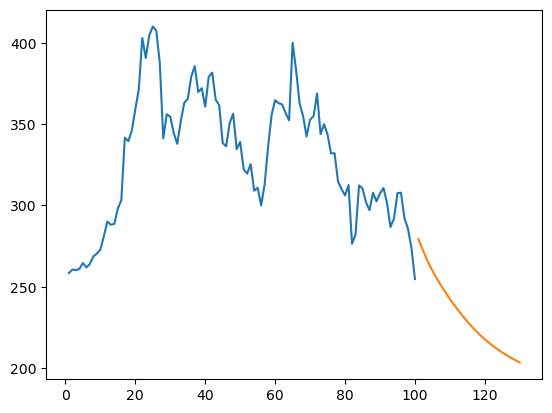

In [61]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [62]:
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [63]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

# Visualizing the same output with inversed transform

In [64]:
df3=scaler.inverse_transform(df3).tolist()

In [65]:
plt.plot(df3)

# Prediction of the next day using 58 previous date data

In [66]:
new_dataframe=pd.read_csv("TSLA.csv")
new_dataframe=new_dataframe.set_index(['Date'],drop=True)
new_dataframe.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-02-16  304.683319  308.809998  300.403320  307.796661  307.796661   
2022-02-17  304.420013  306.166656  291.366669  292.116669  292.116669   
2022-02-18  295.333344  295.623322  279.203339  285.660004  285.660004   
2022-02-22  278.043335  285.576660  267.033325  273.843323  273.843323   
2022-02-23  276.809998  278.433319  253.520004  254.679993  254.679993   

              Volume  
Date                  
2022-02-16  51294300  
2022-02-17  55178400  
2022-02-18  68501700  
2022-02-22  83288100  
2022-02-23  95256900

In [67]:
x=new_dataframe[-60:-2].filter(['Open'])
x

Open
Date                  
2021-11-29  366.996674
2021-11-30  381.456665
2021-12-01  386.899994
2021-12-02  366.353333
2021-12-03  361.596680
2021-12-06  333.836670
2021-12-07  348.066681
2021-12-08  350.903320
2021-12-09  353.546661
2021-12-10  336.250000
2021-12-13  333.696655
2021-12-14  315.000000
2021-12-15  317.736664
2021-12-16  331.500000
2021-12-17  304.923340
2021-12-20  303.566681
2021-12-21  305.623322
2021-12-22  321.886658
2021-12-23  335.600006
2021-12-27  357.890015
2021-12-28  369.829987
2021-12-29  366.213318
2021-12-30  353.776672
2021-12-31  357.813324
2022-01-03  382.583344
2022-01-04  396.516663
2022-01-05  382.216675
2022-01-06  359.000000
2022-01-07  360.123322
2022-01-10  333.333344
2022-01-11  351.223328
2022-01-12  359.616669
2022-01-13  369.690002
2022-01-14  339.959991
2022-01-18  342.203339
2022-01-19  347.236664
2022-01-20  336.576660
2022-01-21  332.113342
2022-01-24  301.586670
2022-01-25  304.733337
2022-01-26  317.476654
2022-01-27  311.119995
2022-01-28  277.186676
2022-01-31  290.903320
2022-02-01  311.736664
2022-02-02  309.393341
2022-02-03  294.000000
2022-02-04  299.073334
2022-02-07  307.929993
2022-02-08  301.843323
2022-02-09  311.666656
2022-02-10  302.790009
2022-02-11  303.209991
2022-02-14  287.190002
2022-02-15  300.000000
2022-02-16  304.683319
2022-02-17  304.420013
2022-02-18  295.333344

In [68]:
scale=scaler.transform(x)

C:\Users\salma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [69]:
scale.shape

(58, 1)

In [70]:
l=[]
l.append(scale)

In [71]:
x_test=np.array(l)
x_test.shape

(1, 58, 1)

In [72]:
x_test2=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test2.shape

(1, 58, 1)

In [73]:
pred=model.predict(x_test2)

1/1 [==============================] - 1s 959ms/step


In [74]:
pred2=scaler.inverse_transform(pred)

In [75]:
print("next day prediction",pred2)


[[288.27576]]


In [76]:
x=new_dataframe[-60:].filter(['Open'])
x

Open
Date                  
2021-11-29  366.996674
2021-11-30  381.456665
2021-12-01  386.899994
2021-12-02  366.353333
2021-12-03  361.596680
2021-12-06  333.836670
2021-12-07  348.066681
2021-12-08  350.903320
2021-12-09  353.546661
2021-12-10  336.250000
2021-12-13  333.696655
2021-12-14  315.000000
2021-12-15  317.736664
2021-12-16  331.500000
2021-12-17  304.923340
2021-12-20  303.566681
2021-12-21  305.623322
2021-12-22  321.886658
2021-12-23  335.600006
2021-12-27  357.890015
2021-12-28  369.829987
2021-12-29  366.213318
2021-12-30  353.776672
2021-12-31  357.813324
2022-01-03  382.583344
2022-01-04  396.516663
2022-01-05  382.216675
2022-01-06  359.000000
2022-01-07  360.123322
2022-01-10  333.333344
2022-01-11  351.223328
2022-01-12  359.616669
2022-01-13  369.690002
2022-01-14  339.959991
2022-01-18  342.203339
2022-01-19  347.236664
2022-01-20  336.576660
2022-01-21  332.113342
2022-01-24  301.586670
2022-01-25  304.733337
2022-01-26  317.476654
2022-01-27  311.119995
2022-01-28  277.186676
2022-01-31  290.903320
2022-02-01  311.736664
2022-02-02  309.393341
2022-02-03  294.000000
2022-02-04  299.073334
2022-02-07  307.929993
2022-02-08  301.843323
2022-02-09  311.666656
2022-02-10  302.790009
2022-02-11  303.209991
2022-02-14  287.190002
2022-02-15  300.000000
2022-02-16  304.683319
2022-02-17  304.420013
2022-02-18  295.333344
2022-02-22  278.043335
2022-02-23  276.809998

In [77]:
plt.scatter(x=x[-3:-2],y=0)

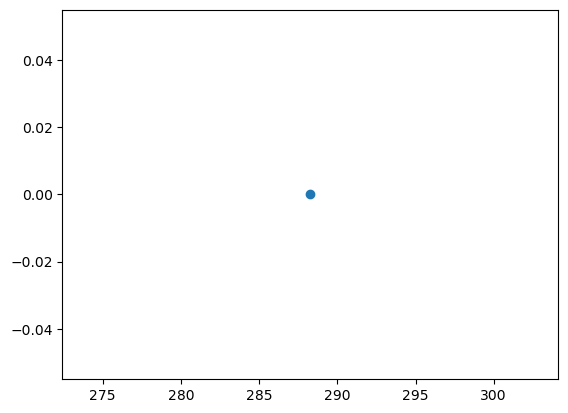

In [78]:
plt.scatter(x=pred2,y=0)

# Trying to predict for the next 10 days

In [100]:
df_future=pd.read_csv("TSLA.csv")
df_future=df_future.set_index(['Date'],drop=True).filter(['Open'])

In [101]:
x=df_future[-100:-40]
x

Open
Date                  
2021-10-01  259.466675
2021-10-04  265.500000
2021-10-05  261.600006
2021-10-06  258.733337
2021-10-07  261.820007
2021-10-08  265.403320
2021-10-11  262.549988
2021-10-12  266.976654
2021-10-13  270.156677
2021-10-14  271.829987
2021-10-15  274.579987
2021-10-18  283.929993
2021-10-19  292.510010
2021-10-20  288.450012
2021-10-21  285.333344
2021-10-22  298.500000
2021-10-25  316.843323
2021-10-26  341.563324
2021-10-27  346.553345
2021-10-28  356.103333
2021-10-29  360.619995
2021-11-01  381.666656
2021-11-02  386.453339
2021-11-03  392.443329
2021-11-04  411.470001
2021-11-05  409.333344
2021-11-08  383.263336
2021-11-09  391.200012
2021-11-10  336.803345
2021-11-11  367.589996
2021-11-12  349.166656
2021-11-15  339.209991
2021-11-16  334.436676
2021-11-17  354.503326
2021-11-18  368.850006
2021-11-19  366.290009
2021-11-22  387.443329
2021-11-23  389.170013
2021-11-24  360.130005
2021-11-26  366.489990
2021-11-29  366.996674
2021-11-30  381.456665
2021-12-01  386.899994
2021-12-02  366.353333
2021-12-03  361.596680
2021-12-06  333.836670
2021-12-07  348.066681
2021-12-08  350.903320
2021-12-09  353.546661
2021-12-10  336.250000
2021-12-13  333.696655
2021-12-14  315.000000
2021-12-15  317.736664
2021-12-16  331.500000
2021-12-17  304.923340
2021-12-20  303.566681
2021-12-21  305.623322
2021-12-22  321.886658
2021-12-23  335.600006
2021-12-27  357.890015

In [102]:
x.shape

(60, 1)

In [103]:
df_future[-100:-40]

Open
Date                  
2021-10-01  259.466675
2021-10-04  265.500000
2021-10-05  261.600006
2021-10-06  258.733337
2021-10-07  261.820007
2021-10-08  265.403320
2021-10-11  262.549988
2021-10-12  266.976654
2021-10-13  270.156677
2021-10-14  271.829987
2021-10-15  274.579987
2021-10-18  283.929993
2021-10-19  292.510010
2021-10-20  288.450012
2021-10-21  285.333344
2021-10-22  298.500000
2021-10-25  316.843323
2021-10-26  341.563324
2021-10-27  346.553345
2021-10-28  356.103333
2021-10-29  360.619995
2021-11-01  381.666656
2021-11-02  386.453339
2021-11-03  392.443329
2021-11-04  411.470001
2021-11-05  409.333344
2021-11-08  383.263336
2021-11-09  391.200012
2021-11-10  336.803345
2021-11-11  367.589996
2021-11-12  349.166656
2021-11-15  339.209991
2021-11-16  334.436676
2021-11-17  354.503326
2021-11-18  368.850006
2021-11-19  366.290009
2021-11-22  387.443329
2021-11-23  389.170013
2021-11-24  360.130005
2021-11-26  366.489990
2021-11-29  366.996674
2021-11-30  381.456665
2021-12-01  386.899994
2021-12-02  366.353333
2021-12-03  361.596680
2021-12-06  333.836670
2021-12-07  348.066681
2021-12-08  350.903320
2021-12-09  353.546661
2021-12-10  336.250000
2021-12-13  333.696655
2021-12-14  315.000000
2021-12-15  317.736664
2021-12-16  331.500000
2021-12-17  304.923340
2021-12-20  303.566681
2021-12-21  305.623322
2021-12-22  321.886658
2021-12-23  335.600006
2021-12-27  357.890015

In [104]:
x.head()

Open
Date                  
2021-10-01  259.466675
2021-10-04  265.500000
2021-10-05  261.600006
2021-10-06  258.733337
2021-10-07  261.820007

In [105]:
x.tail()

Open
Date                  
2021-12-20  303.566681
2021-12-21  305.623322
2021-12-22  321.886658
2021-12-23  335.600006
2021-12-27  357.890015

In [106]:
scaled_data=scaler.transform(x)

C:\Users\salma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [107]:
scaled_data[:5]

array([[0.62188768],
       [0.63704531],
       [0.62724728],
       [0.6200453 ],
       [0.6278    ]])

In [108]:
scaled_data.shape

(60, 1)

In [109]:
l=[]
l.append(scaled_data)
l

[array([[0.62188768],
        [0.63704531],
        [0.62724728],
        [0.6200453 ],
        [0.6278    ],
        [0.63680242],
        [0.62963394],
        [0.64075514],
        [0.64874437],
        [0.65294826],
        [0.65985713],
        [0.68334733],
        [0.70490306],
        [0.69470306],
        [0.68687299],
        [0.71995183],
        [0.7660361 ],
        [0.82814062],
        [0.84067715],
        [0.86466976],
        [0.87601706],
        [0.92889298],
        [0.94091865],
        [0.95596741],
        [1.00376848],
        [0.99840051],
        [0.93290435],
        [0.95284381],
        [0.81618204],
        [0.89352792],
        [0.84724262],
        [0.8222283 ],
        [0.81023621],
        [0.86065003],
        [0.89669347],
        [0.89026194],
        [0.94340582],
        [0.9477438 ],
        [0.87478604],
        [0.89076435],
        [0.89203731],
        [0.92836541],
        [0.94204079],
        [0.89042103],
        [0.8784708 ],
        [0

In [110]:
x_test2=np.array(l)

x_test2.shape

(1, 60, 1)

In [111]:
x_test2[0,-1,0]

0.869158475829288

In [112]:
prediction=model.predict(x_test2.reshape(x_test2.shape[0],x_test2.shape[1],1))

1/1 [==============================] - 0s 23ms/step


In [116]:
pred
pred=prediction.reshape(1,1,1)

In [117]:
pred.shape

(1, 1, 1)

In [118]:
def pred(x_test):
    
    for i in range(1,40):
        pred=model.predict(x_test.reshape(x_test.shape[0],x_test.shape[1],1))
        result.append(pred)
        pred.reshape(1,1,1)
        x_test2=np.concatenate((x_test,pred),axis=1)
        x_test=x_test2
        print(f'x_test2 of the iteration{i}:{x_test2}')
    return result

    

In [119]:
x_test2=x[-60:]
output=[]
scale2=scaler.transform(x_test2)
l=[]
l.append(scale2)
scale=np.array(l)
print(scale.shape)
type(scale)


(1, 60, 1)


C:\Users\salma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


numpy.ndarray

In [120]:
actual=df_future[-41:-36]
actual=np.array(actual)
actual=actual.reshape(5,)
actual.shape

(5,)

In [122]:
output.shape

(0,)

In [123]:
output=np.array(output)
output=output.reshape(5,)
output.shape


ValueError: cannot reshape array of size 0 into shape (5,)

In [124]:
df=pd.DataFrame(data={'actual':actual,'prediction':output})

ValueError: All arrays must be of the same length

In [ ]:
df.plot()

In [125]:

for i in range(5):
    #print(x_test2)
    #print(len(x_test2))
    #x=x.reshape(x.shape[1],x.shape[2])

    pred=model.predict(scale.reshape(scale.shape[0],scale.shape[1],1))
    print("predicted value is ",scaler.inverse_transform(pred.reshape(-1,1)))
    run,output=compute(scale,pred)
    #print(f'monitoring size of run at every run{i} {run.shape}')
    
    scale=run[0][0:run.shape[1]].reshape(run.shape[0],run.shape[1],run.shape[2])
    #print("shape of scale is ",scale.shape)


   

1/1 [==============================] - 0s 17ms/step
predicted value is  [[290.64697]]


NameError: name 'compute' is not defined

In [126]:
output=[]
def compute(scale,pred):
    
    pred2=pred.reshape(1,1,1)
    result=np.concatenate((scale,pred2),axis=1)
    #print("printing  result \n",result)
    #print("shape of result is ",result.shape)
    
    scale=result
    #print("Scale and updated array is \n",scale)
    #print("length of x_test2_updated is ",scale.shape)
    output.append(scaler.inverse_transform(pred.reshape(-1,1)))
    #print("results are \n",output)

    
    return scale,output


In [127]:
scale[0:5]

array([[[0.62188768],
        [0.63704531],
        [0.62724728],
        [0.6200453 ],
        [0.6278    ],
        [0.63680242],
        [0.62963394],
        [0.64075514],
        [0.64874437],
        [0.65294826],
        [0.65985713],
        [0.68334733],
        [0.70490306],
        [0.69470306],
        [0.68687299],
        [0.71995183],
        [0.7660361 ],
        [0.82814062],
        [0.84067715],
        [0.86466976],
        [0.87601706],
        [0.92889298],
        [0.94091865],
        [0.95596741],
        [1.00376848],
        [0.99840051],
        [0.93290435],
        [0.95284381],
        [0.81618204],
        [0.89352792],
        [0.84724262],
        [0.8222283 ],
        [0.81023621],
        [0.86065003],
        [0.89669347],
        [0.89026194],
        [0.94340582],
        [0.9477438 ],
        [0.87478604],
        [0.89076435],
        [0.89203731],
        [0.92836541],
        [0.94204079],
        [0.89042103],
        [0.8784708 ],
        [0

In [128]:
def concat(x):
    output=[]
    for i in range(3):
     
        x_test2=x[i:]
        
        print(x_test2)
        print(len(x_test2))
        #x=x.reshape(x.shape[1],x.shape[2])
        scale2=scaler.transform(x_test2)
        l=[]
        l.append(scale2)
        scale=np.array(l)
        print(scale.shape)
        pred=model.predict(scale.reshape(scale.shape[0],scale.shape[1],1))
        print("predicted value is ",scaler.inverse_transform(pred.reshape(-1,1)))
        if(i>=1):
            pred2=pred.reshape(1,1,1)
            result=np.concatenate((scale,pred2),axis=1)
            print(len(result))
            x=result
            print("length of x_test2_updated is ",x.shape)
            output.append(scaler.inverse_transform(pred.reshape(-1,1)))
    return output
output=concat(x)
print("results are \n",output)


                  Open
Date                  
2021-10-01  259.466675
2021-10-04  265.500000
2021-10-05  261.600006
2021-10-06  258.733337
2021-10-07  261.820007
2021-10-08  265.403320
2021-10-11  262.549988
2021-10-12  266.976654
2021-10-13  270.156677
2021-10-14  271.829987
2021-10-15  274.579987
2021-10-18  283.929993
2021-10-19  292.510010
2021-10-20  288.450012
2021-10-21  285.333344
2021-10-22  298.500000
2021-10-25  316.843323
2021-10-26  341.563324
2021-10-27  346.553345
2021-10-28  356.103333
2021-10-29  360.619995
2021-11-01  381.666656
2021-11-02  386.453339
2021-11-03  392.443329
2021-11-04  411.470001
2021-11-05  409.333344
2021-11-08  383.263336
2021-11-09  391.200012
2021-11-10  336.803345
2021-11-11  367.589996
2021-11-12  349.166656
2021-11-15  339.209991
2021-11-16  334.436676
2021-11-17  354.503326
2021-11-18  368.850006
2021-11-19  366.290009
2021-11-22  387.443329
2021-11-23  389.170013
2021-11-24  360.130005
2021-11-26  366.489990
2021-11-29  366.996674
2021-11-30 

C:\Users\salma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\salma\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: Found array with dim 3. Estimator expected <= 2.

In [129]:
x_test2.shape


(60, 1)

In [130]:
prediction=prediction.reshape(1,1,1)

In [131]:
np.concatenate((x_test2,prediction),axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [132]:
for i in range(0,30):
    x_test2
    

In [ ]:
x_list

In [ ]:
x_test2

In [ ]:
x_list[1]

In [ ]:
def compute(x):
    add=[]
    for i in range(len(x)):
        pred=model.predict(x)
        add=x[i+1:]
        add.append(pred)
         
        
        

# traingin on 3D array

In [ ]:
salman=[[[1,2,3],
        [4,5,6],
        [7,8,9]]]

In [ ]:
salman

In [ ]:
salman[0][2][0]

In [ ]:
type(scale)

In [ ]:
sal2=scale.tolist()

In [ ]:
for i in range(0,60):
    print(sal2[0][i:60+i][0:])
    print("\n",len(sal2[0][i:60+i][0:]))
    print("\n\n*******************")
    

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the sales data into a pandas DataFrame
sales_data = pd.read_csv('TSLA.csv')  # Replace 'sales_data.csv' with your actual data file

# Convert the date column to datetime type
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

# Set the date column as the index
sales_data.set_index('Date', inplace=True)
sales_data=sales_data.filter(['Open'])

# Plot the sales data
sales_data.plot(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Open')
plt.title('Open Time Series')
plt.show()

# Fit an ARIMA model
model = ARIMA(sales_data, order=(1, 1, 1))  # Adjust the order values based on your data
model_fit = model.fit()

# Forecast sales for the next 30 days
forecast = model_fit.forecast(steps=30)

# Print the forecasted values
print(forecast)

# Plot the forecasted sales
plt.plot(sales_data.index, sales_data['Open'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [135]:

# Load the sales data into a pandas DataFrame
new_data = pd.read_csv('TSLA.csv',parse_dates=True,index_col=['Date'])  # Replace 'sales_data.csv' with your actual data file
#new_data=new_data['Open']
new_data=new_data.filter(['Open'])
new_data.head()

Open
Date                 
2017-02-27  16.544666
2017-02-28  16.279333
2017-03-01  16.945333
2017-03-02  16.647333
2017-03-03  16.716000

In [136]:
#new_data=new_data.resample(rule='M').min()
#new_data.head()
#new_data

In [137]:
new_data.isna().sum()

Open    0
dtype: int64

In [138]:
#new_data=new_data.fillna(new_data['Open'].mean())

In [139]:
#new_data.isna().sum()

In [140]:
# Normalize the data using MinMaxScaler
x=np.array(new_data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(x.reshape(-1,1))
scaled_data

array([[0.01119522],
       [0.01053088],
       [0.0121984 ],
       ...,
       [0.70921976],
       [0.66592945],
       [0.66284145]])

In [141]:
scaled_data.shape

(1258, 1)

In [142]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [143]:
train_data.shape,test_data.shape

((880, 1), (378, 1))

In [144]:
# Define the number of previous time steps to consider for prediction
num_steps = 30
def preprocess(num_steps,data):
    # Prepare the training data
    X, y = [], []
    for i in range(num_steps, len(data)):
        X.append(data[i - num_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
X_train,y_train=preprocess(num_steps,train_data)
X_test,y_test=preprocess(num_steps,test_data)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((850, 30), (850,), (348, 30), (348,))

In [145]:
# Reshape the input data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(850, 30, 1)

In [146]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(num_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=16)


Epoch 1/10
54/54 [==============================] - 2s 8ms/step - loss: 8.4093e-04
Epoch 2/10
54/54 [==============================] - 0s 7ms/step - loss: 8.9524e-05
Epoch 3/10
54/54 [==============================] - 0s 8ms/step - loss: 8.3009e-05
Epoch 4/10
54/54 [==============================] - 0s 7ms/step - loss: 8.5878e-05
Epoch 5/10
54/54 [==============================] - 0s 8ms/step - loss: 8.6063e-05
Epoch 6/10
54/54 [==============================] - 0s 8ms/step - loss: 7.6850e-05
Epoch 7/10
54/54 [==============================] - 0s 8ms/step - loss: 7.5952e-05
Epoch 8/10
54/54 [==============================] - 0s 8ms/step - loss: 6.7011e-05
Epoch 9/10
54/54 [==============================] - 0s 8ms/step - loss: 7.2710e-05
Epoch 10/10
54/54 [==============================] - 0s 8ms/step - loss: 6.9373e-05


In [147]:
prediction_of_model=model.predict(X_test)
prediction_of_model

11/11 [==============================] - 0s 4ms/step


array([[0.36772642],
       [0.36779433],
       [0.37085032],
       [0.3720374 ],
       [0.3750094 ],
       [0.3777306 ],
       [0.381095  ],
       [0.38405013],
       [0.38726825],
       [0.3886516 ],
       [0.38746607],
       [0.38495433],
       [0.38589108],
       [0.383282  ],
       [0.37944323],
       [0.3781184 ],
       [0.37572503],
       [0.37264842],
       [0.36952502],
       [0.36469644],
       [0.36325908],
       [0.3653878 ],
       [0.36684483],
       [0.36945066],
       [0.3722602 ],
       [0.37154496],
       [0.3704218 ],
       [0.36921015],
       [0.36746946],
       [0.3656653 ],
       [0.37244648],
       [0.37620288],
       [0.38654003],
       [0.39626533],
       [0.40556395],
       [0.419153  ],
       [0.4322074 ],
       [0.4481421 ],
       [0.46491513],
       [0.47866625],
       [0.4842875 ],
       [0.4944535 ],
       [0.50305355],
       [0.5125425 ],
       [0.5237398 ],
       [0.5375519 ],
       [0.53672993],
       [0.543

# these are for single variate

In [148]:
prediction_of_model

array([[0.36772642],
       [0.36779433],
       [0.37085032],
       [0.3720374 ],
       [0.3750094 ],
       [0.3777306 ],
       [0.381095  ],
       [0.38405013],
       [0.38726825],
       [0.3886516 ],
       [0.38746607],
       [0.38495433],
       [0.38589108],
       [0.383282  ],
       [0.37944323],
       [0.3781184 ],
       [0.37572503],
       [0.37264842],
       [0.36952502],
       [0.36469644],
       [0.36325908],
       [0.3653878 ],
       [0.36684483],
       [0.36945066],
       [0.3722602 ],
       [0.37154496],
       [0.3704218 ],
       [0.36921015],
       [0.36746946],
       [0.3656653 ],
       [0.37244648],
       [0.37620288],
       [0.38654003],
       [0.39626533],
       [0.40556395],
       [0.419153  ],
       [0.4322074 ],
       [0.4481421 ],
       [0.46491513],
       [0.47866625],
       [0.4842875 ],
       [0.4944535 ],
       [0.50305355],
       [0.5125425 ],
       [0.5237398 ],
       [0.5375519 ],
       [0.53672993],
       [0.543

In [149]:
y_test

array([0.32019128, 0.33568967, 0.32875419, 0.3386608 , 0.33978753,
       0.34515394, 0.34559627, 0.34904313, 0.3421995 , 0.33010626,
       0.32255317, 0.33859406, 0.32183542, 0.31331427, 0.32343783,
       0.317362  , 0.31192049, 0.30936662, 0.29860038, 0.31172851,
       0.32916314, 0.32722689, 0.33373673, 0.33657433, 0.3203749 ,
       0.31733698, 0.31616857, 0.31266326, 0.31106084, 0.35382535,
       0.34396047, 0.38039042, 0.38538965, 0.38998822, 0.42078468,
       0.42884684, 0.45480266, 0.47237082, 0.46851502, 0.43417153,
       0.46219716, 0.46302337, 0.47463257, 0.4918168 , 0.51533563,
       0.44913577, 0.48305359, 0.48638361, 0.50664752, 0.49408692,
       0.49405353, 0.52802976, 0.52580977, 0.5105868 , 0.49740025,
       0.5064055 , 0.53271185, 0.52143649, 0.53061701, 0.55397725,
       0.57022678, 0.57373205, 0.6028009 , 0.61877496, 0.684182  ,
       0.67867366, 0.66331717, 0.68147788, 0.67365778, 0.6808436 ,
       0.66899239, 0.68646877, 0.68334738, 0.66607967, 0.68334

Text(0.5, 1.0, "model's prediction of test data")

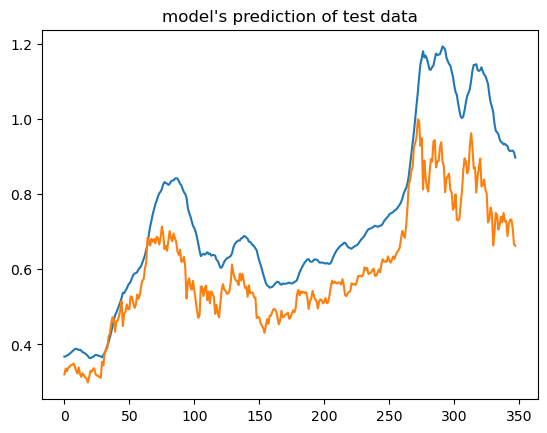

In [150]:
prediction_of_model=prediction_of_model.reshape(prediction_of_model.shape[0],)
plt.plot(prediction_of_model)
plt.plot(y_test)
plt.title("model's prediction of test data")

In [151]:
inputs = scaled_data[len(scaled_data) - num_steps:]
result = []  # Store the predicted results
X_pred = []
for i in range(30):  # Predict for the next 30 days
    #print(f'x_input at iteration {i} is {inputs}')
    X_pred.append(inputs[-num_steps:])
    #print("X_pred list length at each iteration", len(X_pred))
    pred_input1 = np.array(X_pred[-num_steps:])
    #print("Shape of pred_input at each iteration", pred_input1.shape)
    pred_input2 = np.reshape(pred_input1, (pred_input1.shape[0], pred_input1.shape[1], 1))
    pred = model.predict(pred_input2)
    if (i>0):
        result.pop()
    result.append(pred)
    
    #print("Shape of model's prediction", pred.shape)
    inputs = np.concatenate((inputs, pred[0].reshape(1, 1)), axis=0)

# Convert the result list into a NumPy array
result = np.array(result)
print("Shape of predicted results:", result.shape)


1/1 [==============================] - 0s 23ms/step
Shape of predicted results: (1, 30, 1)


In [152]:
result

array([[[0.8857603 ],
        [0.9237162 ],
        [0.95462525],
        [0.9826887 ],
        [1.008077  ],
        [1.0306709 ],
        [1.0506421 ],
        [1.0681841 ],
        [1.0834271 ],
        [1.0967051 ],
        [1.108137  ],
        [1.1178682 ],
        [1.1261753 ],
        [1.1333951 ],
        [1.1394801 ],
        [1.1445258 ],
        [1.14882   ],
        [1.1524855 ],
        [1.1555576 ],
        [1.1580952 ],
        [1.1602334 ],
        [1.1619695 ],
        [1.1634463 ],
        [1.1646558 ],
        [1.1657087 ],
        [1.1665329 ],
        [1.1671875 ],
        [1.1677254 ],
        [1.1681875 ],
        [1.1686116 ]]], dtype=float32)

In [153]:
org_data=scaled_data[len(scaled_data) - num_steps:]
org_data

array([[0.84915579],
       [0.87017084],
       [0.89539222],
       [0.82095492],
       [0.82657176],
       [0.83917408],
       [0.81248381],
       [0.80130866],
       [0.7248767 ],
       [0.73275525],
       [0.76466166],
       [0.74874601],
       [0.66378456],
       [0.69812797],
       [0.75029001],
       [0.74442286],
       [0.70588137],
       [0.71858386],
       [0.74075896],
       [0.7255193 ],
       [0.75011473],
       [0.72788959],
       [0.72894113],
       [0.68883066],
       [0.72090403],
       [0.73263001],
       [0.73197075],
       [0.70921976],
       [0.66592945],
       [0.66284145]])

In [154]:
org_data=scaler.inverse_transform(org_data.reshape(-1,1))
org_data=org_data.reshape(30,)
org_data

array([351.223328, 359.616669, 369.690002, 339.959991, 342.203339,
       347.236664, 336.57666 , 332.113342, 301.58667 , 304.733337,
       317.476654, 311.119995, 277.186676, 290.90332 , 311.736664,
       309.393341, 294.      , 299.073334, 307.929993, 301.843323,
       311.666656, 302.790009, 303.209991, 287.190002, 300.      ,
       304.683319, 304.420013, 295.333344, 278.043335, 276.809998])

In [155]:
pred_data=scaler.inverse_transform(result.reshape(-1,1))
pred_data=pred_data.reshape(30,)
pred_data

array([365.84305, 381.0025 , 393.34747, 404.55594, 414.69595, 423.71988,
       431.69632, 438.70255, 444.79053, 450.09372, 454.65958, 458.54617,
       461.864  , 464.74756, 467.17792, 469.1931 , 470.90823, 472.37222,
       473.5992 , 474.61273, 475.4667 , 476.16013, 476.74994, 477.233  ,
       477.6535 , 477.9827 , 478.24414, 478.459  , 478.64355, 478.81296],
      dtype=float32)

In [156]:
org=np.arange(1,31)
pred=np.arange(31,61)


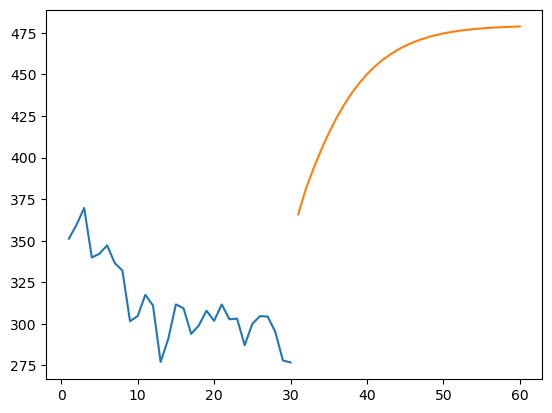

In [157]:
plt.plot(org,org_data)
plt.plot(pred,pred_data)

In [158]:
plt.plot(pred_data)

In [159]:
#of no use 
"""inputs = scaled_data[len(scaled_data) - num_steps:]
# Prepare the input data for prediction
result=[]
X_pred = []
for i in range(30):  # Predict for the next 30 days
    print(f'x_input at iteration {i} is {inputs}')
    X_pred.append(inputs[-num_steps:])
    print("X_pred list length at each iteration", len(X_pred))
    pred_input1 = np.array(X_pred[-num_steps:])
    print("Shape of pred_input at each iteration", pred_input1.shape)
    pred_input2 = np.reshape(pred_input1, (pred_input1.shape[0], pred_input1.shape[1], 1))
    pred = model.predict(pred_input2)
    result.append(pred)
    print("Shape of model's prediction", pred.shape)
    inputs = np.concatenate((inputs, pred[0].reshape(1, 1)), axis=0)
"""

'inputs = scaled_data[len(scaled_data) - num_steps:]\n# Prepare the input data for prediction\nresult=[]\nX_pred = []\nfor i in range(30):  # Predict for the next 30 days\n    print(f\'x_input at iteration {i} is {inputs}\')\n    X_pred.append(inputs[-num_steps:])\n    print("X_pred list length at each iteration", len(X_pred))\n    pred_input1 = np.array(X_pred[-num_steps:])\n    print("Shape of pred_input at each iteration", pred_input1.shape)\n    pred_input2 = np.reshape(pred_input1, (pred_input1.shape[0], pred_input1.shape[1], 1))\n    pred = model.predict(pred_input2)\n    result.append(pred)\n    print("Shape of model\'s prediction", pred.shape)\n    inputs = np.concatenate((inputs, pred[0].reshape(1, 1)), axis=0)\n'

# for multivariate

In [160]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [161]:
# Load the sales data into a pandas DataFrame
new_data = pd.read_csv('TSLA.csv',parse_dates=True,index_col=['Date'])  # Replace 'sales_data.csv' with your actual data file
new_data=new_data[['Open',"High"]]
new_data.head()

Open       High
Date                            
2017-02-27  16.544666  16.557333
2017-02-28  16.279333  16.733334
2017-03-01  16.945333  16.990000
2017-03-02  16.647333  16.885332
2017-03-03  16.716000  16.793333

In [162]:
x=np.array(new_data)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(x)

scaled_data.shape

(1258, 2)

In [163]:
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
print(train_data.shape)
print(test_data.shape)

(880, 2)
(378, 2)


In [164]:
num_steps = 30
def preprocess(num_steps,data):
    # Prepare the training data
    X, y = [], []
    for i in range(num_steps, len(data)):
        X.append(data[i - num_steps:i,:])
        y.append(data[i,:])
    return np.array(X), np.array(y)
X_train,y_train=preprocess(num_steps,train_data)
X_test,y_test=preprocess(num_steps,test_data)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((850, 30, 2), (850, 2), (348, 30, 2), (348, 2))

In [165]:
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(num_steps, train_data.shape[1])))
model.add(Dense(units=train_data.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
54/54 [==============================] - 2s 8ms/step - loss: 6.3341e-04
Epoch 2/10
54/54 [==============================] - 0s 7ms/step - loss: 7.9897e-05
Epoch 3/10
54/54 [==============================] - 0s 7ms/step - loss: 7.5968e-05
Epoch 4/10
54/54 [==============================] - 0s 7ms/step - loss: 8.3531e-05
Epoch 5/10
54/54 [==============================] - 0s 7ms/step - loss: 7.2953e-05
Epoch 6/10
54/54 [==============================] - 0s 7ms/step - loss: 6.5393e-05
Epoch 7/10
54/54 [==============================] - 0s 7ms/step - loss: 6.5122e-05
Epoch 8/10
54/54 [==============================] - 0s 7ms/step - loss: 5.7727e-05
Epoch 9/10
54/54 [==============================] - 0s 7ms/step - loss: 5.3255e-05
Epoch 10/10
54/54 [==============================] - 0s 7ms/step - loss: 6.6893e-05


In [166]:
X_test.shape

(348, 30, 2)

In [167]:
prediction_of_model=model.predict(X_test)
prediction_of_model.shape

11/11 [==============================] - 0s 5ms/step


(348, 2)

In [169]:
y_test.shape

(348, 2)

Text(0.5, 1.0, "model's prediction of test data")

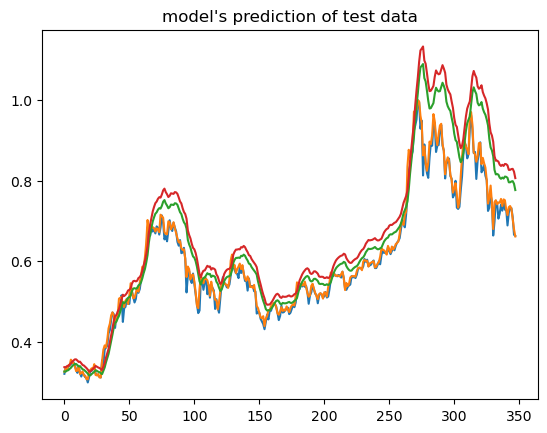

In [170]:
#prediction_of_model=prediction_of_model
plt.plot(y_test,label='Actual')
plt.plot(prediction_of_model)
plt.title("model's prediction of test data")

In [171]:
X_pred = []
data=test_data[-num_steps:, :]
for i in range(30):  # Predict for the next 30 days
    X_pred.append(data[-num_steps:, :])
    #print(f'length of X_pred at iteration{i} {X_pred}')
    #print(X_pred)
    pred_input = np.array(X_pred[-1]).reshape(1, num_steps, train_data.shape[1])
    print("shape of rped_input",pred_input.shape)
    pred = model.predict(pred_input)
    #print("prediction shape",pred.shape)
    data = np.concatenate((data, pred), axis=0)
    print(f'test data at iteration{i} {data.shape}')


shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 18ms/step
test data at iteration0 (31, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 18ms/step
test data at iteration1 (32, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 18ms/step
test data at iteration2 (33, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 24ms/step
test data at iteration3 (34, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 22ms/step
test data at iteration4 (35, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 34ms/step
test data at iteration5 (36, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 24ms/step
test data at iteration6 (37, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 24ms/step
test data at iteration7 (38, 2)
shape of rped_input (1, 30, 2)
1/1 [==============================] - 0s 24ms/st

In [172]:
X_pred[-1]

array([[ 0.66284145,  0.66157716],
       [ 0.76235312,  0.79144698],
       [ 0.7836889 ,  0.81391507],
       [ 0.80595142,  0.83664566],
       [ 0.83052915,  0.86196142],
       [ 0.85766035,  0.89007837],
       [ 0.88752186,  0.92116064],
       [ 0.92037851,  0.95545   ],
       [ 0.95657408,  0.99326348],
       [ 0.9965322 ,  1.03506255],
       [ 1.0407908 ,  1.08135736],
       [ 1.09002316,  1.13282192],
       [ 1.14507377,  1.19031155],
       [ 1.20694828,  1.25486541],
       [ 1.27688158,  1.32774591],
       [ 1.3565371 ,  1.41066217],
       [ 1.44810498,  1.50569677],
       [ 1.55440426,  1.61566687],
       [ 1.67912781,  1.74436176],
       [ 1.82731807,  1.89694941],
       [ 2.00590539,  2.08049679],
       [ 2.22484946,  2.3050561 ],
       [ 2.49852324,  2.58507586],
       [ 2.84767842,  2.94103909],
       [ 3.30432343,  3.40457177],
       [ 3.91886306,  4.02544785],
       [ 4.77135706,  4.88236618],
       [ 5.99035025,  6.10020685],
       [ 7.77761316,

In [173]:
data[-30:]

array([[ 0.76235312,  0.79144698],
       [ 0.7836889 ,  0.81391507],
       [ 0.80595142,  0.83664566],
       [ 0.83052915,  0.86196142],
       [ 0.85766035,  0.89007837],
       [ 0.88752186,  0.92116064],
       [ 0.92037851,  0.95545   ],
       [ 0.95657408,  0.99326348],
       [ 0.9965322 ,  1.03506255],
       [ 1.0407908 ,  1.08135736],
       [ 1.09002316,  1.13282192],
       [ 1.14507377,  1.19031155],
       [ 1.20694828,  1.25486541],
       [ 1.27688158,  1.32774591],
       [ 1.3565371 ,  1.41066217],
       [ 1.44810498,  1.50569677],
       [ 1.55440426,  1.61566687],
       [ 1.67912781,  1.74436176],
       [ 1.82731807,  1.89694941],
       [ 2.00590539,  2.08049679],
       [ 2.22484946,  2.3050561 ],
       [ 2.49852324,  2.58507586],
       [ 2.84767842,  2.94103909],
       [ 3.30432343,  3.40457177],
       [ 3.91886306,  4.02544785],
       [ 4.77135706,  4.88236618],
       [ 5.99035025,  6.10020685],
       [ 7.77761316,  7.87139273],
       [10.43006134,

In [174]:
original_data=scaled_data[-30:]
predicted_data=X_pred[-1]

In [175]:
y_test.shape

(348, 2)

ValueError: x and y must have same first dimension, but have shapes (1, 2) and (30, 2)

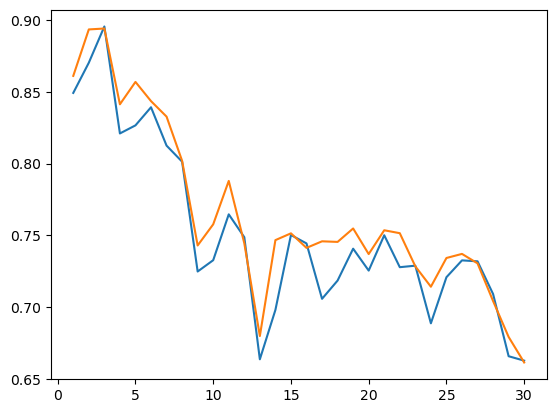

In [176]:
plt.plot(org,original_data)
plt.plot(pred,predicted_data)
plt.title("Actual vs predicted result for the next 30 days for multivariate")

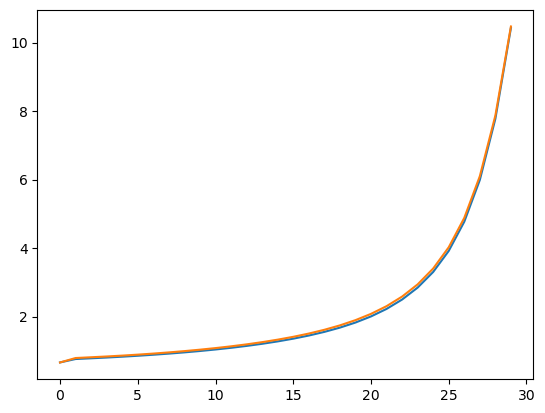

In [177]:
plt.plot(predicted_data)

# Trying for week,month,quarter,and year wise prediction

In [178]:
new_dataframe=new_data.drop(['High'],axis=1)
new_dataframe=new_dataframe.Open.resample(rule='W').mean()

In [179]:
new_dataframe.head()
new_dataframe.tail()

Date
2022-01-30    302.420666
2022-02-06    301.021332
2022-02-13    305.487994
2022-02-20    298.325336
2022-02-27    277.426667
Freq: W-SUN, Name: Open, dtype: float64

<AxesSubplot:xlabel='Date'>

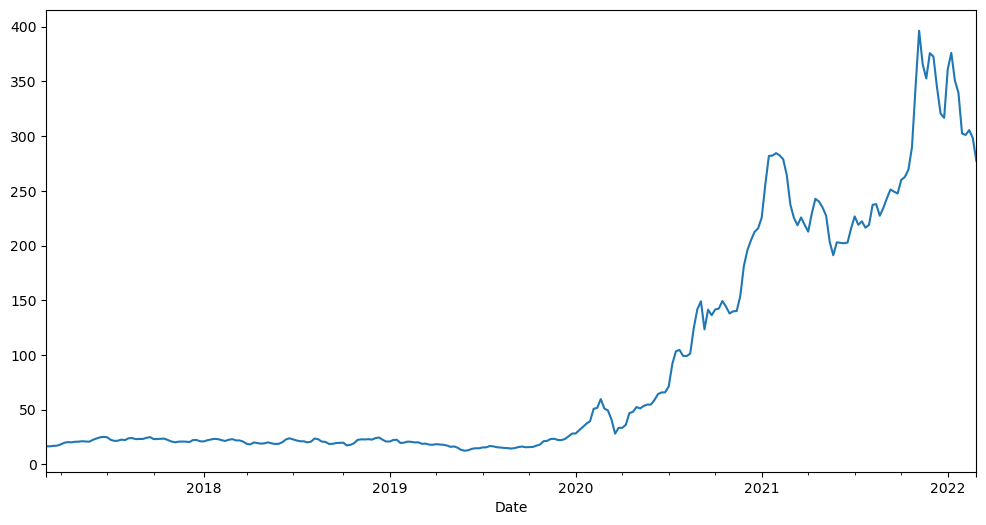

In [180]:
new_dataframe.plot(figsize=(12,6))

In [181]:
x_for_scaling=np.array(new_dataframe)
scaling=scaler.fit_transform(x_for_scaling.reshape(-1,1))

In [182]:
scaling.shape

(261, 1)

In [183]:
train_len=round(len(scaling)*0.7)
train_len

183

In [184]:
training_data=scaling[:train_len]
testing_data=scaling[train_len:]

In [185]:
training_data.shape

(183, 1)

In [186]:
testing_data.shape

(78, 1)

In [187]:
step_size=5
x_train,y_train=preprocess(step_size,training_data)
x_test,y_test=preprocess(step_size,testing_data)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((178, 5, 1), (178, 1), (73, 5, 1), (73, 1))

In [188]:

model2 = Sequential()
model2.add(LSTM(units=64, activation='tanh', input_shape=(step_size, 1),return_sequences=True))
model2.add(LSTM(units=20,activation='tanh',return_sequences=True))
model2.add(LSTM(units=10,activation='tanh',return_sequences=False))
model2.add(Dense(units=5,activation='relu'))
model2.add(Dense(units=1))
model2.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

model2.fit(x_train,y_train,epochs=20)

Epoch 1/20
6/6 [==============================] - 5s 11ms/step - loss: 0.0042 - mean_absolute_error: 0.0347
Epoch 2/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0348
Epoch 3/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0407
Epoch 4/20
6/6 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_absolute_error: 0.0299
Epoch 5/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_absolute_error: 0.0275
Epoch 6/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0333
Epoch 7/20
6/6 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_absolute_error: 0.0299
Epoch 8/20
6/6 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_absolute_error: 0.0238
Epoch 9/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0204
Epoch 10/20
6/6 [==================

In [189]:
train_predict=model2.predict(x_train)
test_predict=model2.predict(x_test)

3/3 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'actual vs predict on training data')

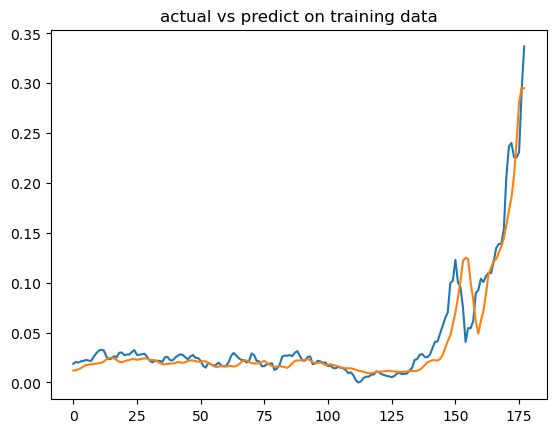

In [190]:
plt.plot(y_train)
plt.plot(train_predict)
plt.title("actual vs predict on training data")

Text(0.5, 1.0, 'actual vs predict on testing data')

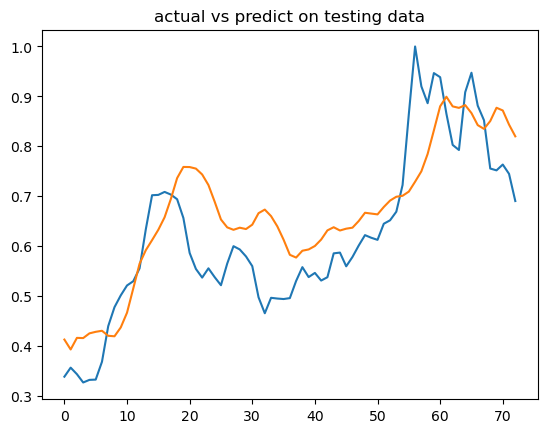

In [191]:
plt.plot(y_test)
plt.plot(test_predict)
plt.title("actual vs predict on testing data")

In [192]:
X_pred2 = []
data2=testing_data[-step_size:,]
for i in range(5):  # Predict for the next 30 days
    X_pred2.append(data2[-step_size:,])
    #print(f'length of X_pred at iteration{i} {X_pred}')
    #print(X_pred)
    pred_input2 = np.array(X_pred2[-1].reshape(1, step_size,1))
    #print("shape of rped_input",pred_input.shape)
    pred2 = model2.predict(pred_input2)
    #print("prediction shape",pred.shape)
    data2 = np.concatenate((data2, pred2), axis=0)
    #print(f'test data at iteration{i} {data2}')


1/1 [==============================] - 0s 25ms/step


In [193]:

original_data2=testing_data[-step_size:,]
predicted_data2=X_pred2[-1:]

In [194]:
original_data2.shape
original_data2=original_data2.reshape(5,)

In [195]:
predicted_data3=np.array(predicted_data2)
predicted_data3

array([[[0.69029176],
        [0.79148984],
        [0.78975505],
        [0.7888574 ],
        [0.78326428]]])

In [196]:
predicted_data3=predicted_data3.reshape(5)

In [197]:
actual=np.arange(1,6)
predict=np.arange(6,11)
plt.plot(actual,scaler.inverse_transform(original_data2.reshape(-1,1)))
plt.plot(predict,scaler.inverse_transform(predicted_data3.reshape(-1,1)))